In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from led_array.bsccm_utils import *
from plot_utils import *
from led_array.bsccm_utils import *
from image_utils import *
from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np
from jax.scipy.linalg import toeplitz


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


## Show concept of gaussian approximations

In [2]:
N_images = 2000

x2_offset = (3, 0)
photons_per_pixel = 220
# channel = 'DPC_Right'
channel = 'LED119'
intensity_space_max = 100

current_photons_per_pixel = np.mean(load_bsccm_images(bsccm, channel, 50, convert_units_to_photons=True))
photon_fraction = photons_per_pixel / current_photons_per_pixel

x1, x2 = read_images_and_sample_intensities(bsccm, channel, x2_offset, N_images, photon_fraction=photon_fraction, median_filter=True)

100%|██████████| 2000/2000 [00:08<00:00, 249.47it/s]


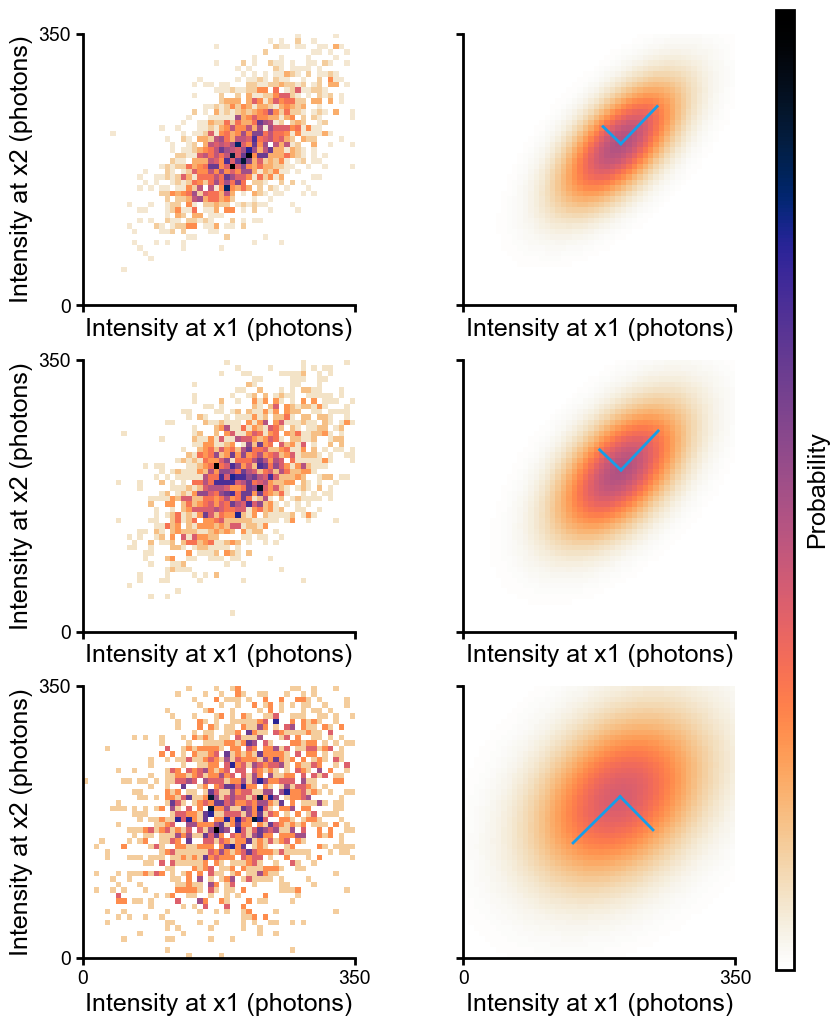

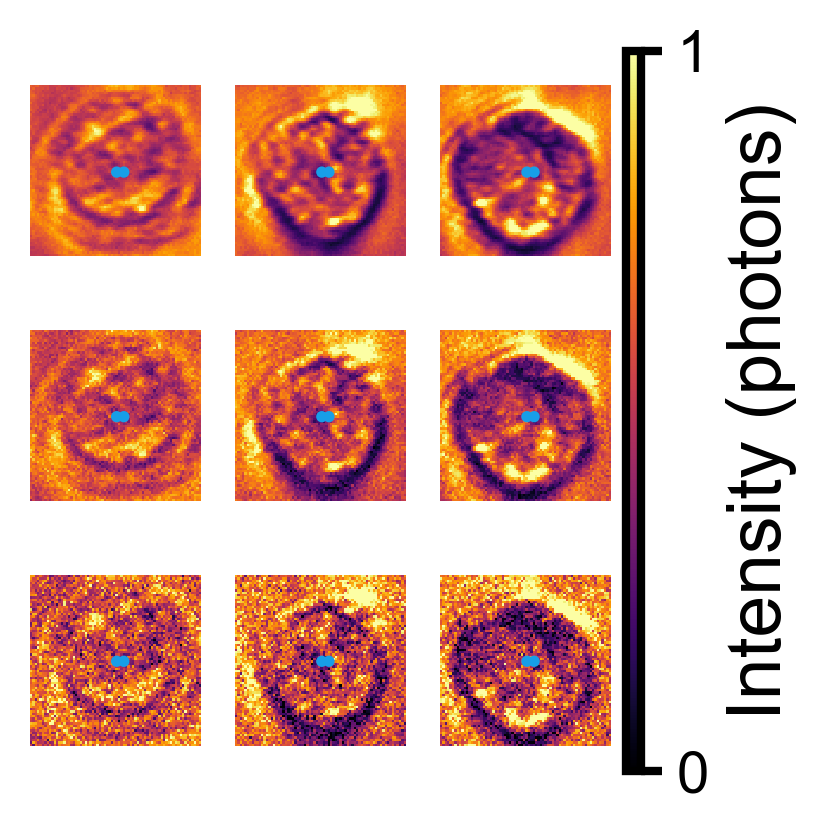

In [3]:
from scipy.stats import multivariate_normal
import cmasher as cmr
from matplotlib.patches import Circle


# display_lim = (30, 80)
display_lim = (0, 350)

num_bins = 50
cmap =  cmr.torch.reversed()
color = get_color_cycle()[0]
# cmap = LinearSegmentedColormap.from_list(f'cmap', [(1,1,1), color])


bins = np.linspace(*display_lim, num_bins + 1)

# additive_gaussian_noise = [0]
additive_gaussian_noise = [0, 20, 50]
fig_dist, ax_dist = plt.subplots(len(additive_gaussian_noise), 2, figsize=(9, 4 * len(additive_gaussian_noise)), sharex=True, sharey=True)
fig_img, ax_img = plt.subplots(len(additive_gaussian_noise), 3, figsize=(2.5, 1 * len(additive_gaussian_noise)), dpi=300)


for row_index, gaussian_sigma in enumerate(additive_gaussian_noise):
    noisy_x1 = x1 + onp.random.normal(0, np.sqrt(x1), size=x1.shape)
    noisy_x2 = x2 + onp.random.normal(0, np.sqrt(x2), size=x2.shape)

    noisy_x1 += onp.random.normal(0, gaussian_sigma, size=x1.shape)
    noisy_x2 += onp.random.normal(0, gaussian_sigma, size=x2.shape)

    # plot a a 2d historgram of the design matrix
    p_x, yedges, xedges = np.histogram2d(noisy_x1, noisy_x2, bins=bins)
    p_x /= p_x.sum()

    design = np.stack([noisy_x1, noisy_x2], axis=1)
    # compute mean and covariance
    mean = np.mean(design, axis=0)
    cov = np.cov(design.T)

    gaussian_pdf = multivariate_normal.pdf(np.stack(
        np.meshgrid(np.linspace(*display_lim, num_bins), np.linspace(*display_lim, num_bins)), axis=-1),  mean=mean, cov=cov)
    gaussian_pdf /= gaussian_pdf.sum()

    # compute vmin and vmax for both plots
    vmin = onp.min([p_x, gaussian_pdf])
    vmax = onp.max([p_x, gaussian_pdf])

    # plot a a 2d historgram of the design matrix
    ax_dist[row_index, 0].imshow(p_x, cmap=cmap, origin='lower', extent=[display_lim[0], display_lim[1], display_lim[0], display_lim[1]], vmin=vmin, vmax=vmax)
    clear_spines(ax_dist[row_index, 0])
    ax_dist[row_index, 0].set(xticks=display_lim, yticks=display_lim, xlabel='Intensity at x1 (photons)', ylabel='Intensity at x2 (photons)')

    # make another plot showing the PDF of the Gaussian
    ax_dist[row_index, 1].imshow(gaussian_pdf, 
        cmap=cmap, origin='lower', extent=[display_lim[0], display_lim[1], display_lim[0], display_lim[1]], vmin=vmin, vmax=vmax)
    # draw the major and minor axes of the ellipse
    eigvals, eigvecs = np.linalg.eigh(cov)
    # plot them
    for eigval, eigvec in zip(np.sqrt(eigvals), eigvecs.T):
        ax_dist[row_index, 1].plot([mean[0], mean[0] +  eigval * eigvec[0]], [mean[1], mean[1] +  eigval * eigvec[1]], color=color, linewidth=2)
    # same formatting as before
    clear_spines(ax_dist[row_index, 1])
    ax_dist[row_index, 1].set(xticks=display_lim, yticks=display_lim, xlabel='Intensity at x1 (photons)')

    # plot example images
    images = np.array([
        load_image_with_synthetic_shot_noise(bsccm, i, channel, photon_fraction=photon_fraction)
         for i in range(3)])

    # now add additional noise for demonstration purposes    
    images += onp.random.normal(0, gaussian_sigma, size=images.shape)
    for i in range(3):
        crop = 28
        cropped_im = images[i][crop:-crop, crop:-crop]
        ax_img[row_index, i].imshow(cropped_im, cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
        ax_img[row_index, i].axis('off')
        ax_img[row_index, i].add_patch(Circle((cropped_im.shape[1] // 2, cropped_im.shape[0] // 2), 1.5, color=color))
        ax_img[row_index, i].add_patch(Circle((cropped_im.shape[1] // 2 + x2_offset[0], cropped_im.shape[0] // 2 + x2_offset[1]), 1.5, color=color))    


# add a colorbar
fig_dist.subplots_adjust(right=0.9)
cbar_ax = fig_dist.add_axes([0.92, 0.1, 0.02, 0.8])
fig_dist.colorbar(cm.ScalarMappable(cmap=cmap), cax=cbar_ax)
# sparse ticks and label "Probability"
cbar_ax.set(yticks=[],  ylabel='Probability')

# add a colorbar
fig_img.subplots_adjust(right=0.9)
cbar_ax = fig_img.add_axes([0.92, 0.1, 0.02, 0.8])
fig_img.colorbar(cm.ScalarMappable(cmap='inferno'), cax=cbar_ax)
# sparse ticks and label "Probability"
cbar_ax.set(yticks=[0, 1],  ylabel='Intensity (photons)')


fig_dist.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'px_gaussian_approx_gaussian_noise' + '.pdf', transparent=True, dpi=600)
fig_img.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'three_example_images_gaussian_noise' + '.pdf', transparent=True, dpi=600)



100%|██████████| 20000/20000 [00:00<00:00, 995255.20it/s]


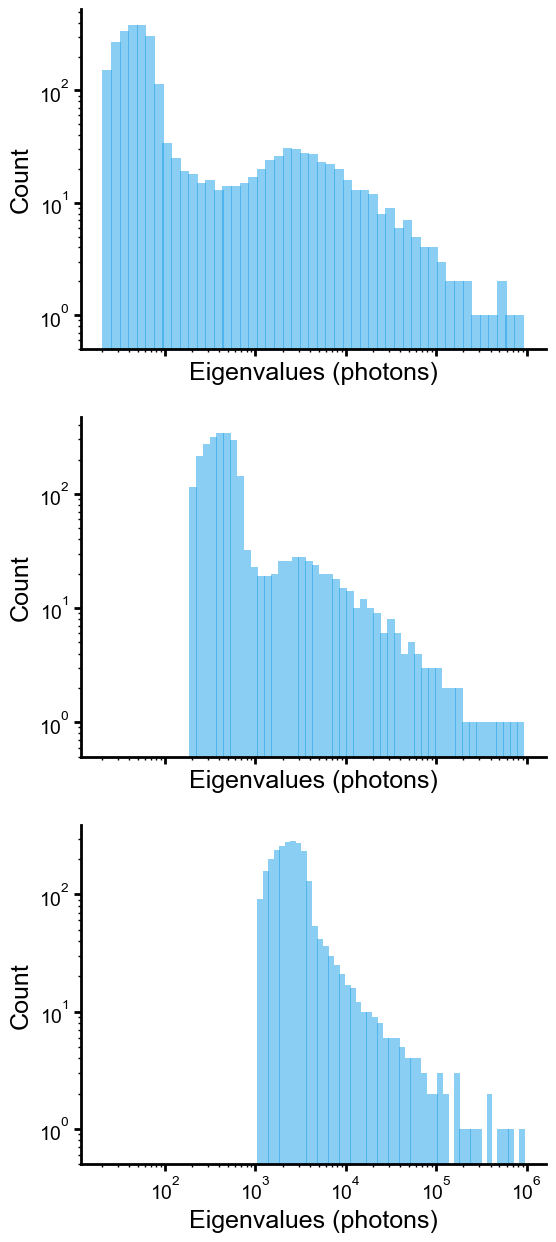

In [4]:
num_images = 1000
patch_size = 50
num_patches = 20000
color = get_color_cycle()[0]

images = load_bsccm_images(bsccm, 'LED119', num_images=num_images, edge_crop=32, convert_units_to_photons=True)
images = add_shot_noise_to_experimenal_data(images, photon_fraction=photon_fraction)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

fig, ax = plt.subplots(3, 1, figsize=(6, 5 * len(additive_gaussian_noise)), sharex=True)

bins = None
for i, noise_level in enumerate(additive_gaussian_noise):
    noisy_patches = patches + noise_level * onp.random.randn(*patches.shape)
    values = compute_eigenvalues(noisy_patches)
    # plot the eigenvalue spectrum
    h = OverlayedHistograms(ax=ax[i])
    h.add(values)
    h.plot(color=color)
    bins = h.bins
    ax[i].set(xlabel='Eigenvalues (photons)', ylabel='Count')
    # , xlim=[20, 1e7])
    clear_spines(ax[i])

fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_eigenvalue_spectrum_different_gaussian_noise' + '.pdf', transparent=True)

## Estimate stationary gaussian processes and draw samples from them

In [4]:
import jax

def compute_cov_mat(patches):
    """
    Take an NxWxH stack of patches, and compute the covariance matrix of the vectorized patches
    """
    patches = np.array(patches)
    vectorized_patches = patches.reshape(patches.shape[0], -1).T
    # center on 0
    vectorized_patches = vectorized_patches - np.mean(vectorized_patches, axis=1, keepdims=True)
    return np.cov(vectorized_patches)

# trying to add jit to this somehow makes it run slower
def compute_stationary_cov_mat(patches):
    """
    Uses images patches to estimate the covariance matrix of a stationary 2D process.
    The covariance matrix of such a process will be doubly toeplitz--i.e. a toeplitz matrix
    of blocks, each of which itself is a toeplitz matrix. The raw covariance matrix calculated
    from the patches is not doubly toeplitz, so we need to average over all elements that should 
    be the same as each other within this structure.
    """
    cov_mat = compute_cov_mat(patches)
    # split it into individual blocks
    block_size = patches.shape[-1]
    # divide it into blocks
    blocks = [np.hsplit(row, cov_mat.shape[1]//block_size) for row in np.vsplit(cov_mat, cov_mat.shape[0]//block_size)]

    toeplitz_blocks = {}
    for i in range(len(blocks)):
        for j in range(len(blocks[0])):
            id = (i - j)
            if id not in toeplitz_blocks:
                toeplitz_blocks[id] = []
            toeplitz_blocks[id].append(blocks[i][j])

    # compute the mean of each block
    toeplitz_block_means = {id: np.mean(np.stack(blocks, axis=0), axis=0) for id, blocks in toeplitz_blocks.items()}

    # now repeat the process within each block
    j, i = np.meshgrid(np.arange(block_size), np.arange(block_size))
    differences = abs(i - j)
    masks = np.array([differences == id for id in np.arange(block_size)])
    for block_id, block in tqdm(dict(toeplitz_block_means.items()).items()):
        diag_values = []
        for mask in masks:
            diag_values.append(np.sum(np.where(mask, block, 0)) / np.sum(mask))            
        # create a new topelitz matrix from the diagonal values
        toeplitz_block_means[block_id] = toeplitz(np.array(diag_values))

    # now reconstruct the full doubly toeplitz matrix from the blocks
    new_blocks = []
    for i in range(len(blocks)):
        row = []
        for j in range(len(blocks[0])):
            id = abs(i - j)
            row.append(toeplitz_block_means[id])
        new_blocks.append(np.hstack(row))
    stationary_cov_mat = np.vstack(new_blocks)
    return stationary_cov_mat

def sample_multivariate_gaussian(cholesky, seed):
    """
    Generate a sample from multivariate gaussian with zero mean given the cholesky decomposition of its covariance matrix
    """
    key = jax.random.PRNGKey(seed)
    mvn_sample = jax.random.multivariate_normal(key, np.zeros(cholesky.shape[0]), np.eye(cholesky.shape[0]))
    # mvn_sample = onp.random.normal(size=cholesky.shape[0])
    sample = np.array(cholesky) @ mvn_sample
    sampled_image = sample.reshape((int(np.sqrt(sample.size)), int(np.sqrt(sample.size))))
    return sampled_image

def make_positive_definite(A, starting_threshold=1e-2):
    """
    ensure the matrix is positive definite by adding a small value to the eigenvalues
    start small and iteratively increase the threshold until the matrix is positive definite
    """
    # IMPORTANT: This has to run using regular numpy, not jax.numpy, because
    # jax.numpy has weird, possibly buggy behavior when computing eigenvalues
    # and gives different results than numpy
    eigvals, eigvecs = onp.linalg.eigh(A)
    if np.min(eigvals) > 0:
        return A
    threshold = starting_threshold
    while onp.min(eigvals) <= 0:
        print('Matrix not positive definite. Adding {} to eigenvalues'.format(threshold))
        eigvals = onp.where(eigvals < threshold, threshold, eigvals)
        new_matrix = eigvecs @ onp.diag(eigvals) @ eigvecs.T
        eigvals, eigvecs = onp.linalg.eigh(new_matrix)
        threshold *= 2
    return new_matrix

def expand_stationary_covariance_matrix(cov_mat, new_patch_size):
    """
    Expand the covariance matrix of a stationary Gaussian process to a larger size
    This is done by extending the diagonal blocks, and padding zeros in extra space
    
    cov_mat : The covariance matrix of a stationary Gaussian process
    new_patch_size : int that is the one dimensional shape of a patch that the new
      covariance matrix represents the size of the covariance matrix is the patch size squared
    """
    old_patch_size = int(onp.sqrt(cov_mat.shape[0]))

    def expand_existing_block(block):
        """
        Expand an existing block (a singly toeplitz matrix) by extending along the diagonal
        """
        line = onp.concatenate([block[0], onp.zeros(new_patch_size - old_patch_size)])
        return toeplitz(line)
    
    num_block_rows_old = cov_mat.shape[0] // old_patch_size
    num_block_cols_old = cov_mat.shape[1] // old_patch_size

    new_cov_mat_size = new_patch_size ** 2
    new_cov_mat = onp.zeros((new_cov_mat_size, new_cov_mat_size))
    for block_i in range(new_cov_mat.shape[0] // new_patch_size):
        for block_j in range(new_cov_mat.shape[1] // new_patch_size):
            position = abs(block_i - block_j)
            if position < num_block_rows_old:
                new_cov_mat[block_i * new_patch_size:(block_i + 1) * new_patch_size, 
                            block_j * new_patch_size:(block_j + 1) * new_patch_size] = expand_existing_block(
                                cov_mat[position * old_patch_size:(position + 1) * old_patch_size, 
                                        position * old_patch_size:(position + 1) * old_patch_size])
    return new_cov_mat



In [2]:
num_images = 1000
num_patches = 20000
patch_size = 50
edge_crop = 0


num_patches_to_show = 8
channels = 'LED119'

images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

print('computing cov mat')
cov_mat = compute_stationary_cov_mat(patches)
print('making positive definite')
cov_mat = make_positive_definite(cov_mat, starting_threshold=1e-10)
# cov_mat = compute_cov_mat(patches) # non-stationary version


fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(cov_mat, cmap='inferno')



print('expanding cov mat')
cov_mat = expand_stationary_covariance_matrix(cov_mat, patch_size + 1)
print('making positive definite again')
cov_mat = make_positive_definite(cov_mat, starting_threshold=1e-10)

print('computing cholesky decomposition')
cholesky = onp.linalg.cholesky(cov_mat)

# plot the cov mat
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(cov_mat, cmap='inferno')


# plot some example patches and samples from the gaussian process
fig, ax = plt.subplots(2, num_patches_to_show, figsize=(num_patches_to_show, 2))
for j in tqdm(range(num_patches_to_show)):
    ax[0, j].imshow(patches[j], cmap='inferno')
    ax[0, j].axis('off')
    sample = sample_multivariate_gaussian(cholesky, seed=j)
    ax[1, j].imshow(sample, cmap='inferno')
    ax[1, j].axis('off')

NameError: name 'channel' is not defined

100%|██████████| 20000/20000 [00:00<00:00, 1025000.98it/s]


computing cov mat


100%|██████████| 99/99 [00:02<00:00, 39.33it/s]


making positive definite
Matrix not positive definite. Adding 0.01 to eigenvalues
computing cholesky decomposition


100%|██████████| 20000/20000 [00:00<00:00, 911319.84it/s]


computing cov mat


100%|██████████| 99/99 [00:02<00:00, 38.09it/s]


making positive definite
Matrix not positive definite. Adding 0.01 to eigenvalues
computing cholesky decomposition


100%|██████████| 20000/20000 [00:00<00:00, 945824.04it/s]


computing cov mat


100%|██████████| 99/99 [00:02<00:00, 36.16it/s]


making positive definite
Matrix not positive definite. Adding 0.01 to eigenvalues
computing cholesky decomposition


100%|██████████| 8/8 [00:00<00:00, 60.04it/s]


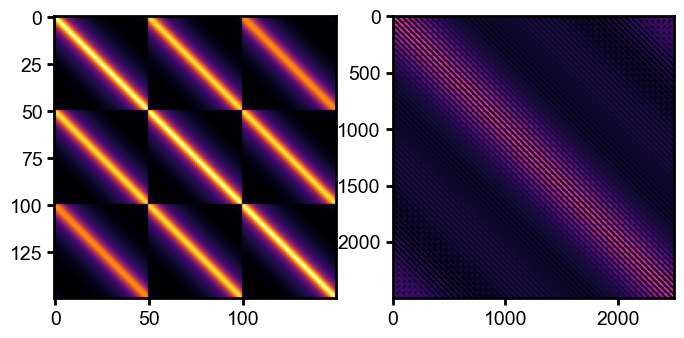

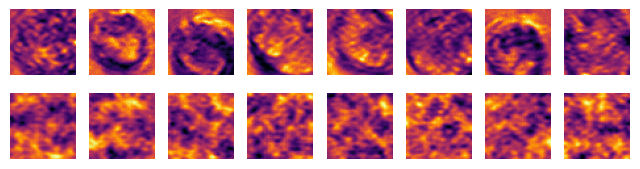

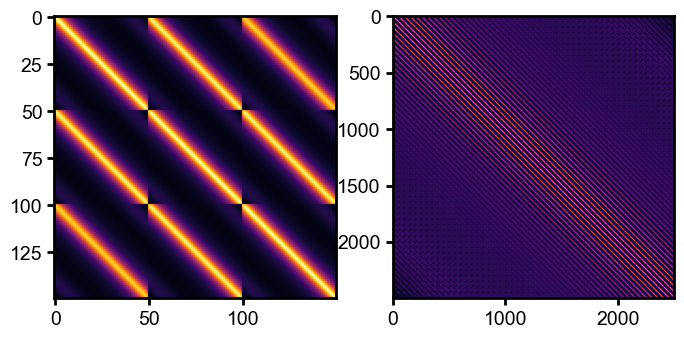

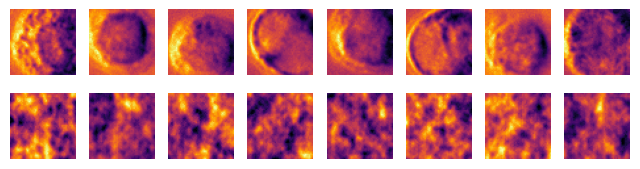

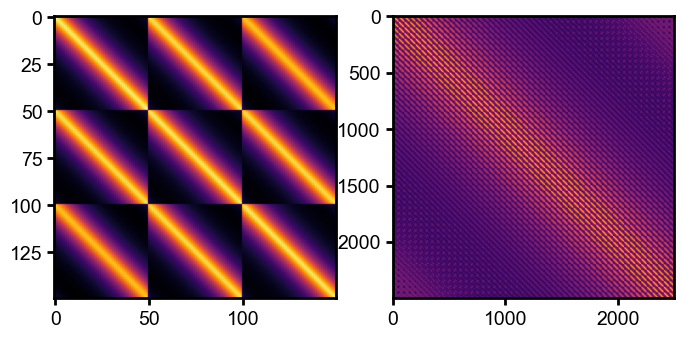

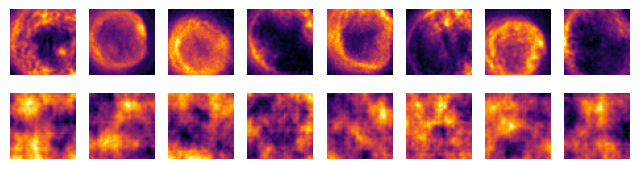

In [9]:
num_images = 1000
num_patches = 20000
patch_size = 50
edge_crop = 32


num_patches_to_show = 8
channels = ['LED119', 'DPC_Right', 'DF_50']
# channels = ['LED119', 'DPC_Right']
# channels = ['LED119']

for channel in channels:
    images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True)
    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

    print('computing cov mat')
    cov_mat = compute_stationary_cov_mat(patches)
    print('making positive definite')
    cov_mat = make_positive_definite(cov_mat)
    # cov_mat = compute_cov_mat(patches) # non-stationary version

    # print('expanding cov mat')
    # cov_mat = expand_stationary_covariance_matrix(cov_mat, patch_size * 2)
    # print('making positive definite again')
    # cov_mat = make_positive_definite(cov_mat, starting_threshold=1e-10)

    print('computing cholesky decomposition')
    cholesky = onp.linalg.cholesky(cov_mat)
    
    # plot the cov mat
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(cov_mat[:150, :150], cmap='inferno')
    ax[1].imshow(cov_mat, cmap='inferno')

    # plot some example patches and samples from the gaussian process
    fig, ax = plt.subplots(2, num_patches_to_show, figsize=(num_patches_to_show, 2))
    for j in tqdm(range(num_patches_to_show)):
        ax[0, j].imshow(patches[j], cmap='inferno')
        ax[0, j].axis('off')
        sample = sample_multivariate_gaussian(cholesky, seed=j)
        ax[1, j].imshow(sample, cmap='inferno')
        ax[1, j].axis('off')

    
